In [1]:
import os
import openai
import datetime
import pandas as pd
import json
import PyPDF2 as pdf
from PyPDF2 import PdfReader
import numpy as np
import time

In [2]:
file = open("Manuals/WLAN Manual/WLAN Manual.pdf","rb")
reader = PdfReader(file)
info = []
for i in range(0, len(reader.pages)):
    info.append(reader.pages[i].extract_text())
    info.append(" ")

In [3]:
api_key_file = open("OPENAI_API_KEY", "r")
openai.api_key = api_key_file.read()

In [4]:
info = np.array([[j for j in i] for i in info])
final_info = []
for i in info:
    for j in i: 
            final_info.append(j)
            
final_info = ''.join(final_info).replace('\n',' ')

/var/folders/9g/btnfbnzs5s98j60gmhcn4fnh0000gn/T/ipykernel_61012/221502225.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  info = np.array([[j for j in i] for i in info])


In [5]:
from IPython.display import Image, display

def show_relevant_image(img_src):
    display(Image(filename=img_src))

    return "Image Shown to User"

In [6]:
premise = "You’re an image and technical support bot that has access to manuals, and can make analysis and inferences to what may be helpful for a technical support person when they want to find a problem with the product, and point to relevant info. Some of the provided manuals have image sources, and you will always use the show_relevant_images function to show the images with anything you say if the explanation is at all related. If there is no relevant image, you will say say there is no relevant image. This means that you always use the show_relevant_image function to display the image when anything related to the image is mentioned by the user without asking the user if they want to see the image. This is very important, that the image is always shown without the user asking for it. Make sure to display images promptly in all responses. All of your information is based on the manuals. You can only refer to the manuals. Always link the source of the manuals. The manual information is here: "
premise = premise + final_info
messages=[
    {"role": "system", "content": premise}
      ]
functions=[{
                "name": "show_relevant_image",
                "description": "Always Run this function with the image sources. A function that displays an image to the user.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "img_src": {
                            "type": "string",
                            "description": "The source of the image that is to be displayed"
                        },
                    },
                    "required": ["img_src"],
                },
            }
]

def conversation(response):
    content = response + "Do this according to the manual. Show an image if there is one."
    messages.append({"role": "user", "content": content})
    
    completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions, function_call = "auto",
    )
    message = completion["choices"][0]["message"]
    

    if message.get("function_call"):
        function_name = message["function_call"]["name"]
        arguments = json.loads(message["function_call"]["arguments"])
        
        #Image Function
        if function_name == "show_relevant_image":
            function_response = show_relevant_image(arguments['img_src'])
            
        else:
            raise NotImplementedError()
        
        messages.append({"role":"function","name":function_name,"content":function_response})
        second_response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages = messages,
        )
        answer_response = second_response.choices[0]["message"]["content"].strip()
        messages.append({"role": "assistant", "content": answer_response})
    
    
    #Normal Block
    else:
        chat_response = completion.choices[0].message.content
        messages.append({"role": "assistant", "content": chat_response})
    
    for i in messages:
        if i['role'] == "user":
            print("User: ", i['content'][0:-63])
            #print("\n")
        elif i['role'] == "assistant":
            print("ChatGPT: ", i['content'])
        print("\n")
        
    return (response,messages[-1]["content"])
 
    time.sleep(15)
    

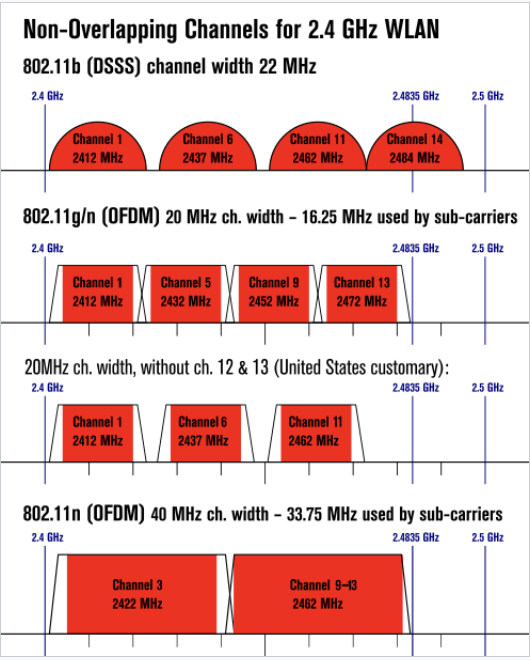



User:  Tell me about 2.4ghz




ChatGPT:  The 2.4 GHz range is a commonly used frequency band for wireless LAN (WLAN) communications. It is supported by various IEEE 802.11 protocols, including 802.11b, 802.11g, 802.11n, and 802.11ax. In this frequency range, there are a total of fourteen designated channels.

These channels are spaced 5 MHz apart from each other, except for a 12 MHz space before channel 14. It is important to note that in the 2.4 GHz bands, bonded 40 MHz channels have unique names based on primary and secondary 20 MHz channels (e.g., 9+13). In the 5 GHz bands, they are denoted by the center of the wider band and the primary 20 MHz channel (e.g., 42[40]).

In the United States, operation on channels 12 and 13 is allowed under low-power conditions. However, channel 14 can only be used for specific modulation methods in Japan. It is also worth mentioning that different countries may have their own regulations regarding channel usage, allowed users, and maximum power le

('Tell me about 2.4ghz',
 'The 2.4 GHz range is a commonly used frequency band for wireless LAN (WLAN) communications. It is supported by various IEEE 802.11 protocols, including 802.11b, 802.11g, 802.11n, and 802.11ax. In this frequency range, there are a total of fourteen designated channels.\n\nThese channels are spaced 5 MHz apart from each other, except for a 12 MHz space before channel 14. It is important to note that in the 2.4 GHz bands, bonded 40 MHz channels have unique names based on primary and secondary 20 MHz channels (e.g., 9+13). In the 5 GHz bands, they are denoted by the center of the wider band and the primary 20 MHz channel (e.g., 42[40]).\n\nIn the United States, operation on channels 12 and 13 is allowed under low-power conditions. However, channel 14 can only be used for specific modulation methods in Japan. It is also worth mentioning that different countries may have their own regulations regarding channel usage, allowed users, and maximum power levels within t

In [13]:
conversation("Tell me about 2.4ghz")

In [7]:
from tkinter import *
 
# GUI
root = Tk()
root.title("Chatbot")
 
BG_GRAY = "#ABB2B9"
BG_COLOR = "#17202A"
TEXT_COLOR = "#EAECEE"
 
FONT = "Helvetica 14"
FONT_BOLD = "Helvetica 13 bold"
 
# Send function
def send():
    cur_text = e.get()
    send = "You - " + cur_text
    txt.insert(END, "\n" + send)
    
    user = e.get().lower()
    
    latest_tuple = conversation(cur_text)
    txt.insert(END, "\n" + latest_tuple[1])
#     if (user == "hello"):
#         txt.insert(END, "\n" + "Bot -> Hi there, how can I help?")
 
#     elif (user == "hi" or user == "hii" or user == "hiiii"):
#         txt.insert(END, "\n" + "Bot -> Hi there, what can I do for you?")
 
#     elif (user == "how are you"):
#         txt.insert(END, "\n" + "Bot -> fine! and you")
 
#     elif (user == "fine" or user == "i am good" or user == "i am doing good"):
#         txt.insert(END, "\n" + "Bot -> Great! how can I help you.")
 
#     elif (user == "thanks" or user == "thank you" or user == "now its my time"):
#         txt.insert(END, "\n" + "Bot -> My pleasure !")
 
#     elif (user == "what do you sell" or user == "what kinds of items are there" or user == "have you something"):
#         txt.insert(END, "\n" + "Bot -> We have coffee and tea")
 
#     elif (user == "tell me a joke" or user == "tell me something funny" or user == "crack a funny line"):
#         txt.insert(
#             END, "\n" + "Bot -> What did the buffalo say when his son left for college? Bison.! ")
 
#     elif (user == "goodbye" or user == "see you later" or user == "see yaa"):
#         txt.insert(END, "\n" + "Bot -> Have a nice day!")
 
#     else:
#         txt.insert(END, "\n" + "Bot -> Sorry! I didn't understand that")
 
    e.delete(0, END)
 
 
lable1 = Label(root, bg=BG_COLOR, fg=TEXT_COLOR, text="Welcome", font=FONT_BOLD, pady=10, width=20, height=1).grid(
    row=0)
 
txt = Text(root, bg=BG_COLOR, fg=TEXT_COLOR, font=FONT, width=60)
txt.grid(row=1, column=0, columnspan=2)
 
scrollbar = Scrollbar(txt)
scrollbar.place(relheight=1, relx=0.974)
 
e = Entry(root, bg="#2C3E50", fg=TEXT_COLOR, font=FONT, width=55)
e.grid(row=2, column=0)
 
send = Button(root, text="Send", font=FONT_BOLD, bg=BG_GRAY,
              command=send).grid(row=2, column=1)
 
root.mainloop()

Exception ignored in: <function Image.__del__ at 0x7f8a207995e0>
Traceback (most recent call last):
  File "/Users/houkinwan/opt/anaconda3/lib/python3.9/tkinter/__init__.py", line 4015, in __del__
    if self.name:
AttributeError: 'Image' object has no attribute 'name'
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/houkinwan/opt/anaconda3/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/var/folders/9g/btnfbnzs5s98j60gmhcn4fnh0000gn/T/ipykernel_61012/3855753872.py", line 22, in send
    latest_tuple = conversation(cur_text)
  File "/var/folders/9g/btnfbnzs5s98j60gmhcn4fnh0000gn/T/ipykernel_61012/306961768.py", line 40, in conversation
    function_response = show_relevant_image(arguments['img_src'])
  File "/var/folders/9g/btnfbnzs5s98j60gmhcn4fnh0000gn/T/ipykernel_61012/609550905.py", line 4, in show_relevant_image
    display(Image(filename=img_src))
TypeError: __init__() missing 1 required positional argu